In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import shutil
from tqdm import tqdm

/data/aglinska/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import skvideo
import skvideo.io

In [3]:
def load_video(fn):
    import skvideo
    import skvideo.io
    videodata = skvideo.io.vread(fn)
    return videodata

In [4]:
def save_video(videodata,ofn='outvideo.mp4'):
    import skvideo
    import skvideo.io
    #skvideo.io.vwrite(ofn, videodata.astype(np.uint8),outputdict={'-codec': 'h264', '-filter:v' : 'fps=29.97'})
    skvideo.io.vwrite(ofn, videodata.astype(np.uint8))

In [5]:
def plot_video(videodata):
    plt.figure(figsize=(15,5))
    for c,i in enumerate(np.floor(np.linspace(0,videodata.shape[0]-1,5))):
        plt.subplot(1,5,c+1)
        plt.axis('off')
        plt.imshow(videodata[int(i),:,:,0:3])
    plt.show()

In [6]:
def safe_mkdir(fn):
    import os
    if not os.path.exists(fn):
        os.mkdir(fn)

In [7]:
def safe_mkdir_subdirs(fn):
    fn_split = fn.split('/')
    n = len(fn.split('/'))
    paths = ['/'.join(fn_split[0:i]) for i in range(0,n) if len('/'.join(fn_split[0:i]))>1]
    for path in paths:
        safe_mkdir(path)

In [8]:
def plot_triple(mask1,mask2):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1);plt.imshow(mask1,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.subplot(1,3,2);plt.imshow(mask2/2,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.subplot(1,3,3);plt.imshow(mask1+mask2/2,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.tight_layout()

In [9]:
def bg_inpaint(bg,mask,inpaint_radius=3,inpainting=cv2.INPAINT_TELEA):
    #cv2.INPAINT_TELEA or cv2.INPAINT_NS)
    #bg_inpainted = cv2.inpaint((bg[:,:,0:3]*255).astype(np.uint8),mask,inpaint_radius,inpainting)
    bg_inpainted = cv2.inpaint((bg[:,:,0:3]).astype(np.uint8),mask,inpaint_radius,inpainting)
    return bg_inpainted

In [10]:
masks = np.load('./Data/data_good_videos_1p_masks.npz')['arr']
fns = np.load('./Data/data_good_videos_1p_fns.npz')['arr']
paddings = np.load('./Data/data_good_videos_1p_paddings.npz')['arr']

In [11]:
masks.shape

(4060, 360, 640)

In [12]:
%%time
filled_spots = np.load('./Data/data_inpainting_idx_filled_spots.npz')['arr']
spots_found_for = np.load('./Data/data_inpainting_idx_spots_found_for.npz')['arr']
where_to_inpaint_idx = np.load('./Data/data_inpainting_idx_where_to_inpaint_idx.npz')['arr']
masks_to_inpaint = np.load('./Data/data_inpainting_idx_masks_to_inpain.npz')['arr']

CPU times: user 20.9 s, sys: 1.79 s, total: 22.7 s
Wall time: 23 s


In [13]:
masks_to_inpaint.shape

(4060, 360, 640)

In [14]:
filled_spots.mean()

0.5433497536945813

In [15]:
filled_spots.sum()

2206

In [16]:
(spots_found_for * filled_spots).sum()

1521

In [17]:
good_idxs = np.nonzero((spots_found_for * filled_spots))[0]
good_idxs

array([   1,    3,    4, ..., 4046, 4057, 4059])

72
116


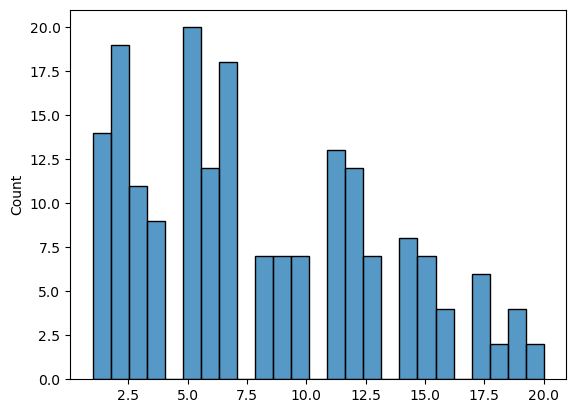

In [18]:
all_cats = np.array([fns[good_idxs][i].split('/')[-2] for i in range(good_idxs.shape[0])]);
u,c = np.unique(all_cats,return_counts=True);
sns.histplot(c,bins=25);

print((c>=10).sum())
print((c>=6).sum())

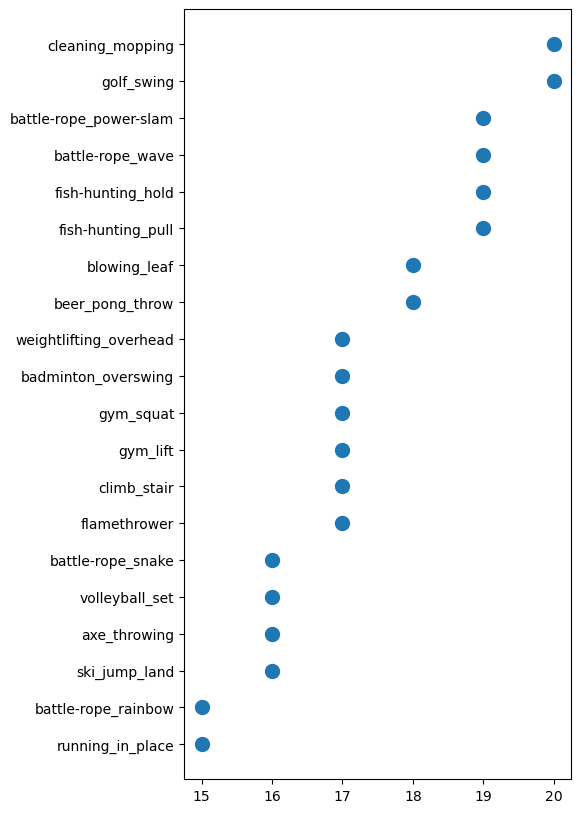

In [19]:
I = np.argsort(c)[::-1]
plt.figure(figsize=(5,10))
n = 20
xs = np.arange(n)
plt.plot(c[I][0:n][::-1],xs,'.',markersize=20)
plt.yticks(np.arange(n),labels=u[I][0:n][::-1],rotation=0);

In [20]:
len(good_idxs)

1521

In [21]:
make_manual_check = False
if make_manual_check:
    safe_mkdir('./Data/dataset-v2-manual-check/')
    for i in tqdm(good_idxs):
    #for i in tqdm(range(len(good_idxs))):
        ## ^ WHAT THE FUCK IS THIS
        ## has to loop over goodidx not range
        ## ARGH!
         
        plt.ioff()
        video_data_where_fn = fns[int(i)].replace('_item_0_masks.npy','.mp4')
        video_data_where_seg_fn = fns[int(i)].replace('_item_0_masks.npy','_item_0_fwd_seg.mp4')

        video_data_where = load_video(video_data_where_fn)
        video_data_where_seg = load_video(video_data_where_seg_fn)

        plt.figure(figsize=(15,5))

        videodata = video_data_where
        for c,j in enumerate(np.floor(np.linspace(0,videodata.shape[0]-1,5))):
                plt.subplot(2,5,c+1)
                plt.axis('off')
                plt.imshow(videodata[int(j),:,:,0:3])

        videodata = video_data_where_seg
        for c,j in enumerate(np.floor(np.linspace(0,videodata.shape[0]-1,5))):
                plt.subplot(2,5,c+1+5)
                plt.axis('off')
                plt.imshow(videodata[int(j),:,:,0:3])

        plt.suptitle(video_data_where_fn)
        plt.tight_layout()

        plt.savefig(f'./Data/dataset-v2-manual-check/{int(i)}.jpg')
        plt.close()

In [22]:
#!zip -r './Data/dataset-v2-manual-check.zip' './Data/dataset-v2-manual-check/'

In [86]:
manual_check_good = np.load('./Data/manual_check_good.npy')

In [87]:
manual_check_good

array([   3,    4,    8, ..., 4034, 4046, 4057])

In [88]:
good_idxs = manual_check_good
#good_idxs = np.array([good_idxs[i] for i in manual_check_good])

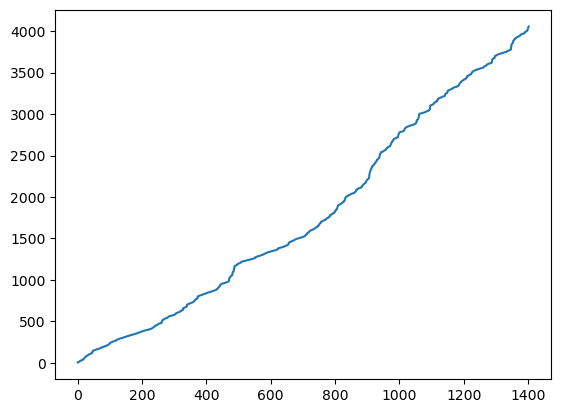

In [89]:
plt.plot(np.sort(good_idxs))

66
105


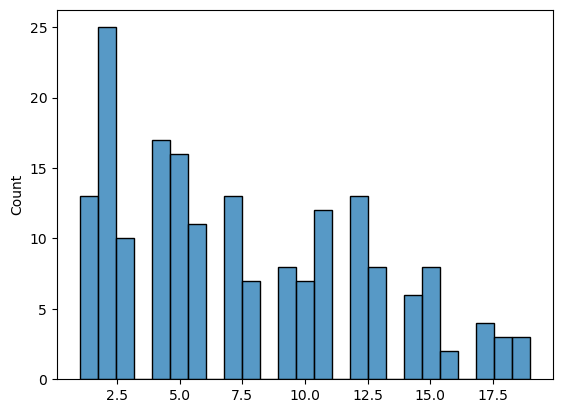

In [90]:
all_cats = np.array([fns[good_idxs][i].split('/')[-2] for i in range(good_idxs.shape[0])]);
u,c = np.unique(all_cats,return_counts=True);
sns.histplot(c,bins=25);

print((c>=10).sum())
print((c>=6).sum())

In [91]:
# make dataset folder
dataset_name = 'dataset-v3'
safe_mkdir(os.path.join('./Data',dataset_name))

In [28]:
for i in tqdm(range(len(good_idxs))):

    which = good_idxs[i]
    where = int(where_to_inpaint_idx[which])

    video_data_where_fn = fns[where].replace('_item_0_masks.npy','.mp4')
    video_data_where_seg_fn = fns[where].replace('_item_0_masks.npy','_item_0_fwd_seg.mp4')
    video_data_where_inp_fn = fns[where].replace('_item_0_masks.npy','_item_0_inp_seg.mp4')
    
    # Make Category subfolder
    category = fns[where].split('/')[-2]
    out_folder = os.path.join('./Data',dataset_name,category)
    safe_mkdir(out_folder)
    
    dst_video_data_where_fn = os.path.join(out_folder,video_data_where_fn.split('/')[-1])
    dst_video_data_where_seg_fn = os.path.join(out_folder,video_data_where_seg_fn.split('/')[-1])
    dst_video_data_where_inp_fn = os.path.join(out_folder,video_data_where_inp_fn.split('/')[-1])
    dst_video_data_where_inp = os.path.join(out_folder,video_data_where_seg_fn.split('/')[-1]).replace('_fwd_seg.mp4','_bg_rnd.mp4')
    
    if not all([os.path.exists(path) for path in [dst_video_data_where_fn,dst_video_data_where_seg_fn,dst_video_data_where_inp_fn,dst_video_data_where_inp]]):
    
        video_data_where = load_video(video_data_where_fn)
        video_data_where_seg = load_video(video_data_where_seg_fn)
        video_data_where_bg = load_video(video_data_where_inp_fn)
        video_data_where_inp = np.array([bg_inpaint(video_data_where[frame,:,:,:],mask=(masks_to_inpaint[which]*255).astype(np.uint8),inpaint_radius=3,inpainting=cv2.INPAINT_TELEA) for frame in range(video_data_where.shape[0])])

        do_plot = False
        if do_plot:
            plot_triple(masks_to_inpaint[which],masks[where,:,:]+paddings[where,:,:])
            plot_video(video_data_where)
            plot_video(video_data_where_seg)
            plot_video(video_data_where_inp)
            plot_video(video_data_where_bg)

        # Copy over original    
        shutil.copyfile(src=video_data_where_fn, 
                        dst=dst_video_data_where_fn)

        # Copy over BG removed
        shutil.copyfile(src=video_data_where_seg_fn, 
                        dst=dst_video_data_where_seg_fn)
        # Copy over BG only 
        shutil.copyfile(src=video_data_where_inp_fn, 
                        dst=dst_video_data_where_inp_fn)

        # Write BG RND
        save_video(video_data_where_inp,dst_video_data_where_inp)



100%|█████████████████████████████████████| 1403/1403 [1:08:06<00:00,  2.91s/it]


In [68]:
#len(np.unique(good_idxs))==len(good_idxs)
#len(np.unique(where_to_inpaint_idx))==len(where_to_inpaint_idx)
#len(np.unique(where_to_inpaint_idx[good_idxs])) == len(where_to_inpaint_idx[good_idxs])

True

In [69]:
which

14

In [78]:
where_to_inpaint_idx[0:5]

array([2828.,  830., 1106., 3253., 1529.])

In [79]:
spots_found_for

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
where_to_inpaint_idx[0:5]

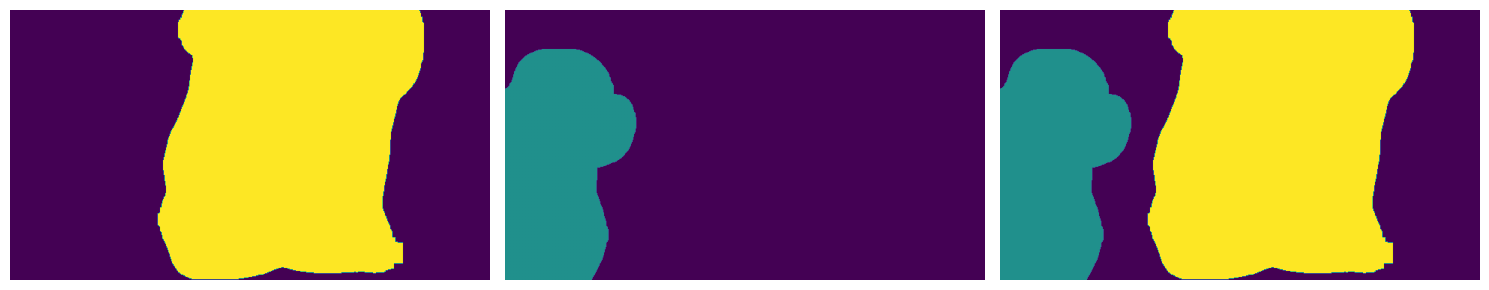

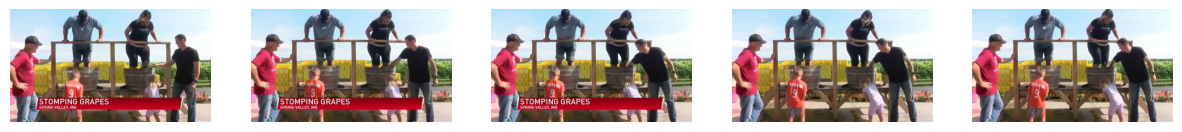

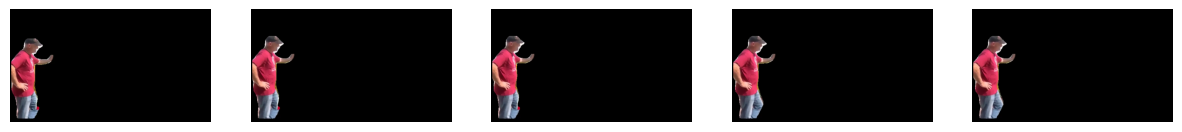

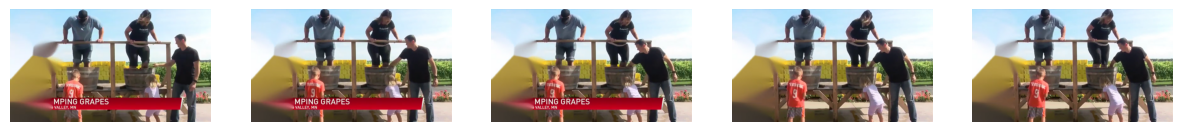

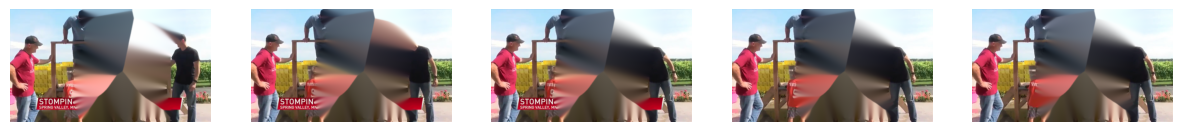

In [95]:
i = 0

which = good_idxs[i]
where = int(where_to_inpaint_idx[which])

video_data_where_fn = fns[where].replace('_item_0_masks.npy','.mp4')
video_data_where_seg_fn = fns[where].replace('_item_0_masks.npy','_item_0_fwd_seg.mp4')
video_data_where_inp_fn = fns[where].replace('_item_0_masks.npy','_item_0_inp_seg.mp4')

# Make Category subfolder
category = fns[where].split('/')[-2]
out_folder = os.path.join('./Data',dataset_name,category)
safe_mkdir(out_folder)

dst_video_data_where_fn = os.path.join(out_folder,video_data_where_fn.split('/')[-1])
dst_video_data_where_seg_fn = os.path.join(out_folder,video_data_where_seg_fn.split('/')[-1])
dst_video_data_where_inp_fn = os.path.join(out_folder,video_data_where_inp_fn.split('/')[-1])
dst_video_data_where_inp = os.path.join(out_folder,video_data_where_seg_fn.split('/')[-1]).replace('_fwd_seg.mp4','_bg_rnd.mp4')

#if not all([os.path.exists(path) for path in [dst_video_data_where_fn,dst_video_data_where_seg_fn,dst_video_data_where_inp_fn,dst_video_data_where_inp]]):

video_data_where = load_video(video_data_where_fn)
video_data_where_seg = load_video(video_data_where_seg_fn)
video_data_where_bg = load_video(video_data_where_inp_fn)
video_data_where_inp = np.array([bg_inpaint(video_data_where[frame,:,:,:],mask=(masks_to_inpaint[which]*255).astype(np.uint8),inpaint_radius=3,inpainting=cv2.INPAINT_TELEA) for frame in range(video_data_where.shape[0])])

do_plot = True
if do_plot:
    plot_triple(masks_to_inpaint[which],masks[where,:,:]+paddings[where,:,:])
    plot_video(video_data_where)
    plot_video(video_data_where_seg)
    plot_video(video_data_where_bg)
    plot_video(video_data_where_inp)
    

# # Copy over original    
# shutil.copyfile(src=video_data_where_fn, 
#                 dst=dst_video_data_where_fn)

# # Copy over BG removed
# shutil.copyfile(src=video_data_where_seg_fn, 
#                 dst=dst_video_data_where_seg_fn)
# # Copy over BG only 
# shutil.copyfile(src=video_data_where_inp_fn, 
#                 dst=dst_video_data_where_inp_fn)

# # Write BG RND
# save_video(video_data_where_inp,dst_video_data_where_inp)

In [30]:

chech_done = np.array([os.path.exists(os.path.join(  './Data',dataset_name,'/'.join(fns[i].split('/')[-2::]).replace('_item_0_masks.npy','.mp4')  )) for i in good_idxs])
print(chech_done.mean())



0.5980042765502495


In [38]:
fns[good_idxs[5]]

'/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg4/CPR/CPR_014_item_0_masks.npy'

In [48]:
i = good_idxs[5]
os.path.exists(os.path.join(  './Data',dataset_name,'/'.join(fns[i].split('/')[-2::]).replace('_item_0_masks.npy','.mp4')))

False

In [49]:
print(os.path.join(  './Data',dataset_name,'/'.join(fns[i].split('/')[-2::]).replace('_item_0_masks.npy','.mp4')))

./Data/dataset-v3/CPR/CPR_014.mp4


In [30]:
folders = os.listdir(os.path.join('./Data',dataset_name))
folders.sort()
folders = np.array(folders)

num_vid = [len(os.listdir(os.path.join('./Data',dataset_name,folder)))/4 for folder in folders]
num_vid = np.array(num_vid)

In [31]:
sum(num_vid>=10)

45

In [32]:
safe_mkdir(os.path.join('./Data','dataset-v3-10'))

In [33]:
for folder in tqdm(folders[num_vid>=10]):
    shutil.copytree(os.path.join('./Data',dataset_name,folder),
               os.path.join('./Data','dataset-v3-10',folder))

100%|███████████████████████████████████████████| 45/45 [00:05<00:00,  8.80it/s]


In [37]:
#!zip -r './Data/dataset-v3-10.zip' './Data/dataset-v3-10'

In [34]:
len(os.listdir('./Data/dataset-v3-10') )

45